# Nonadiabatic Dynamics of 24-mode Pyrazine

In this quickstart guide, we apply pyTTN to evaluate the non-adiabatic dynamics of the 24-mode pyrazine model following excitation to the $S_2$ elecronic state.  This model is a standard benchmark model for software aimed at simulating quantum dynamics of molecular systems.  Here we make use of the standard quadratic vibronic Hamiltonian presented in [A. Raab, G. A. Worth, H.-D. Meyer, L. S. Cederbaum, J. Chem. Phys. 110, 936–946 (1999)](https://doi.org/10.1063/1.478061).

$$ 
\begin{split}
\hat{H} &= \sum_{i=1}^{24} \omega_i \left( - \frac{\partial^2 }{\partial Q_i^2} + Q_i^2\right) - \Delta \hat{\sigma}_z 
         + \sum_{i\in G_1} \left( a_i \ket{0}\bra{0} + b_i \ket{1} \bra{1} \right) Q_i  \\ &+ \sum_{i\in G_3} c_i \hat{\sigma}_x Q_i 
    +\sum_{(i,j)\in G_2}\left( a_{ij} \ket{0}\bra{0} + b_{ij} \ket{1}\bra{1} \right) Q_i Q_j +\sum_{(i,j)\in G_4}c_{ij} \hat{\sigma}_x Q_i Q_j  
\end{split}
    $$


Here we are interested in the dynamics of the system starting from the initial state:
$$ \ket{\Psi(0)} = \ket{S_2} \bigotimes_{k=1}^{24} \ket{0}_k $$

and will evaluate the autocorrelation
$$    a(t) = \braket{\Psi(0)}{\Psi(t)} = \braket{\Psi(t/2)^*}{\Psi(t/2)} $$
and shifted and scaled spectrum 
$$    I(\omega) \propto \int_0^{t_{\mathrm{max}}} \mathrm{Re}\left[a(t) e^{-\frac{t}{\tau}} \cos\left(\frac{\pi t}{2t_{\mathrm{max}}}\right) e^{i\omega t} \right]\mathrm{d} t $$



### Contents


1. [Importing the Package](#importing-the-package)

2. [Setting up the System and Hamiltonian](#setting-up-the-system-and-hamiltonian)

3. [Preparing the Initial Wavefunction](#preparing-the-initial-wavefunction)

4. [Preparing the pyttn.pyttn.sOP_operator Representation of the Hamiltonian](#preparing-the-pyttn.sOP_operator-hamiltonian)

5. [Running the Dynamics](#running-the-dynamics)


### Importing the Package

We start by importing the required modules for this example

In [5]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn.utils import visualise_tree

### Setting up the System and Hamiltonian

The construction of the pyrazine model Hamiltonian that we consider in this section is considerably more involved than was the case for the spin models we have considered in previous examples.  This is due to the large number of distinct vibronic coupling constants with different forms depending on the symmetry of the vibrational modes.  

##### Vibrational Mode Labels

In order to define the Hamiltonian, we will start by labelling the vibrational modes and construct the various groupings of the modes:

In [6]:
#convert from eV to hartree
eV = 0.0367493049512081

def modes():
    return ['el', 'v10a', 'v6a', 'v1', 'v9a', 'v8a', 'v2', 'v6b', 'v8b', 'v4', 'v5', 'v3', 'v16a', 'v12', 'v13', 'v19b', 'v18b', 'v18a', 'v14', 'v19a', 'v17a', 'v20b', 'v16b' , 'v11', 'v7b']

def mode_index(mode):
    return modes().index(mode)

def vibrational_mode_index(mode):
    return modes().index(mode)-1

def Ag():
    return ['v6a', 'v1', 'v9a', 'v8a', 'v2']

def B1g():
    return ['v10a']

def B2g():
    return ['v4' , 'v5']

def B3g():
    return ['v6b', 'v3', 'v8b', 'v7b']

def Au():
    return ['v16a', 'v17a']

def B1u():
    return ['v12', 'v18a', 'v19a', 'v13']

def B2u():
    return ['v18b', 'v14', 'v19b', 'v20b']

def B3u():
    return ['v16b', 'v11']


def G1():
    return Ag()

def G2(): 
    return [ Ag(), Au(), B1g(), B2g(), B3g(), B1u(), B2u(), B3u()]

def G3():
    return B1g()

def G4():
    G4i = [B1g(), B2g(), Au(), B3u()]
    G4j = [Ag(), B3g(), B1u(), B2u()]
    return G4i, G4j

##### Hamiltonian Parameter Definition

Next we go ahead and define the physical parameters of the system:

In [7]:
def w():
    return {
        'v6a' : 0.0739*eV, 
        'v1'  : 0.1258*eV, 
        'v9a' : 0.1525*eV, 
        'v8a' : 0.1961*eV, 
        'v2'  : 0.3788*eV, 
        'v10a': 0.1139*eV,
        'v4'  : 0.0937*eV, 
        'v5'  : 0.1219*eV,
        'v6b' : 0.0873*eV, 
        'v3'  : 0.1669*eV, 
        'v8b' : 0.1891*eV, 
        'v7b' : 0.3769*eV,
        'v16a': 0.0423*eV, 
        'v17a': 0.1190*eV,
        'v12' : 0.1266*eV, 
        'v18a': 0.1408*eV, 
        'v19a': 0.1840*eV, 
        'v13' : 0.3734*eV,
        'v18b': 0.1318*eV, 
        'v14' : 0.1425*eV, 
        'v19b': 0.1756*eV, 
        'v20b': 0.3798*eV,
        'v16b': 0.0521*eV, 
        'v11' : 0.0973*eV
    }


def ai():
    return np.array([-0.0981,-0.0503, 0.1452,-0.0445, 0.0247])*eV

def bi():
    return np.array([ 0.1355,-0.1710, 0.0375, 0.0168, 0.0162])*eV

def aij():
    ret = [
        np.array(
            [[       0, 0.00108,-0.00204,-0.00135,-0.00285], 
             [       0,       0, 0.00474, 0.00154,-0.00163],
             [       0,       0,       0, 0.00872,-0.00474],
             [       0,       0,       0,       0,-0.00143],
             [       0,       0,       0,       0,       0]]
        )*eV,
        np.array(
            [[ 0.01145, 0.00100],
             [       0,-0.02040]]
        )*eV,
        np.array(
            [[-0.01159]]
        )*eV,
        np.array(
            [[-0.02252,-0.00049],
             [       0,-0.01825]]
        )*eV,
        np.array(
            [[-0.00741, 0.01321,-0.00717, 0.00515],
             [       0, 0.05183,-0.03942, 0.00170],
             [       0,       0,-0.05733,-0.00204],
             [       0,       0,       0,-0.00333]]
        )*eV,

        np.array(
            [[-0.04819, 0.00525,-0.00485,-0.00326],
             [       0,-0.00792, 0.00852, 0.00888],
             [       0,       0,-0.02429,-0.00443],
             [       0,       0,       0,-0.00492]]

        )*eV,
        np.array(
            [[-0.00277, 0.00016,-0.00250, 0.00357],
             [       0, 0.03924,-0.00197,-0.00355],
             [       0,       0, 0.00992, 0.00623],
             [       0,       0,       0,-0.00110]]

        )*eV,
        np.array(
            [[-0.02176,-0.00624],
             [       0, 0.00315]]
        )*eV
    ]
    for i in range(len(ret)):
        ret[i] = ret[i] + ret[i].T
        np.fill_diagonal(ret[i], ret[i].diagonal()/2)
    return ret

def bij():
    ret = [
        np.array(
            [[       0,-0.00298,-0.00189,-0.00203,-0.00128], 
             [       0,       0, 0.00155, 0.00311,-0.00600],
             [       0,       0,       0, 0.01194,-0.00334],
             [       0,       0,       0,       0,-0.00713],
             [       0,       0,       0,       0,       0]]
        )*eV,
        np.array(
            [[-0.01459,-0.00091],
             [       0,-0.00618]]
        )*eV,
        np.array(
            [[-0.01159]]
        )*eV,

        np.array(
            [[-0.03445, 0.00911],
             [       0,-0.00265]]
        )*eV,
        np.array(
            [[-0.00385,-0.00661, 0.00429,-0.00246],
             [       0, 0.04842,-0.03034,-0.00185],
             [       0,       0,-0.06332,-0.00388],
             [       0,       0,       0,-0.00040]]
        )*eV,

        np.array(
            [[-0.00840, 0.00536,-0.00097, 0.00034],
             [       0, 0.00429, 0.00209,-0.00049],
             [       0,       0,-0.00734, 0.00346],
             [       0,       0,       0, 0.00062]]

        )*eV,
        np.array(
            [[-0.01179,-0.00844, 0.07000,-0.01249],
             [       0, 0.04000,-0.05000, 0.00265],
             [       0,       0, 0.01246,-0.00422],
             [       0,       0,       0, 0.00069]]

        )*eV,
        np.array(
            [[-0.02214,-0.00261],
             [       0,-0.00496]]
        )*eV
    ]
    for i in range(len(ret)):
        ret[i] = ret[i] + ret[i].T
        np.fill_diagonal(ret[i], ret[i].diagonal()/2)
    return ret


def ci():
    return np.array([0.2080])*eV


def cij():
    return [
        np.array(
            [[-0.01000,-0.00551, 0.00127, 0.00799,-0.00512]]
        )*eV,
        np.array(
            [[-0.01372,-0.00466, 0.00329,-0.00031],
             [ 0.00598,-0.00914, 0.00961, 0.00500]]
        )*eV,
        np.array(
            [[-0.01056, 0.00559, 0.00401,-0.00226],
             [-0.01200,-0.00213, 0.00328,-0.00396]]
        )*eV,
        np.array(
            [[ 0.00118,-0.00009,-0.00285,-0.00095],
             [ 0.01281,-0.01780, 0.00134,-0.00481]]
        )*eV
    ]

##### Hamiltonian Definition

Having done so we can now define the Hamiltonian for the system.  Here we have made use of a user defined `pyttn.operator_dictionary` to allow for specification of custom operators acting on the electronic system subspace.

In [8]:

def hamiltonian():
    N = len(modes())
    H = pyttn.SOP(N)
    omegas = w()
    vs = modes()[1:]
    
    delta = 0.8460/2.0*eV

    #set up the system operator dictionary
    opdict = pyttn.operator_dictionary(N)
    for i in range(2):
        v = np.zeros( (2,2), dtype=np.complex128)
        v[i, i] = 1.0
        op =  pyttn.site_operator(v, optype="matrix", mode=0)
        opdict.insert(0, "|%d><%d|"%(i, i), op)

    v = np.zeros( (2,2), dtype=np.complex128)
    v[0, 0] = 1.0
    v[1, 1] = -1.0
    op =  pyttn.site_operator(v, optype="matrix", mode=0)
    opdict.insert(0, "sz", op)

    v = np.zeros( (2,2), dtype=np.complex128)
    v[0, 1] = 1.0
    v[1, 0] = 1.0
    op =  pyttn.site_operator(v, optype="matrix", mode=0)
    opdict.insert(0, "sx", op)

    #energy spacing of the S1 and S2 state
    H += -delta*pyttn.sOP("sz", 0)

    #add on the vibrational mode terms
    for v in vs:
        H += omegas[v]*pyttn.sOP("n", mode_index(v))

    #the linear on-diagonal couplings
    for i, g in enumerate(G1()):
        H += ai()[i]*pyttn.sOP("|0><0|", 0)*pyttn.sOP("q", mode_index(g))
        H += bi()[i]*pyttn.sOP("|1><1|", 0)*pyttn.sOP("q", mode_index(g))

    #the quadratic on-diagonal couplings
    for g, Aij, Bij in zip(G2(), aij(), bij()):
        for i, vi in enumerate(g):
            for j, vj in enumerate(g):
                H += Aij[i, j]*pyttn.sOP("|0><0|", 0)*pyttn.sOP("q", mode_index(vi))*pyttn.sOP("q", mode_index(vj))
                H += Bij[i, j]*pyttn.sOP("|1><1|", 0)*pyttn.sOP("q", mode_index(vi))*pyttn.sOP("q", mode_index(vj))

    #the linear off-diagonal couplings
    for i, g in enumerate(G3()):
        H += ci()[i]*pyttn.sOP("sx", 0)*pyttn.sOP("q", mode_index(g))

    #the quadratic on-diagonal couplings
    G4i, G4j = G4()
    for gi, gj, Cij in zip(G4i, G4j, cij()):
        for i, vi in enumerate(gi):
            for j, vj in enumerate(gj):
                H += Cij[i, j]*pyttn.sOP("sx", 0)*pyttn.sOP("q", mode_index(vi))*pyttn.sOP("q", mode_index(vj))
    return H, opdict


##### System Definition

We now prepare the `system_modes` operators and construct the `pyttn.sOP` representation of the Hamiltonian using the functions defined above:

In [9]:

#The total number of modes in the system
N = 25          

#The dimension of each of the bosonic modes
m = [40, 32, 20, 12, 8, 4, 8, 24, 24, 8, 8, 24, 20, 4, 72, 80, 6, 20, 6, 6, 6, 32, 6, 4]

#The composite mode definition
composite_modes = [[0, 1], [2, 3, 4], [5, 6, 7], [8, 9, 10], [11, 12, 13], [14, 15], [16, 17, 18, 19], [20, 21, 22, 23]]
Nc = len(composite_modes)

composite_mode_dimensions = []
#set up the system information object
sysinf = pyttn.system_modes(Nc+1)
sysinf[0] = pyttn.generic_mode(2)
for ind, comb in enumerate(composite_modes):
    sysinf[ind+1] = [pyttn.boson_mode(m[x]) for x in comb]

#set up the sum of product operator Hamiltonian and operator dictionary
H, opdict = hamiltonian()  

### Preparing the Initial Wavefunction

We now prepare the initial wavefunction.  This requires a two-step process, first we define the tree topology to use for this calculation through the use of the `ntree` class (which for this example we choose to be an MPS), following which we construct the `ttn` object that actually represents the wavefunction.  In this example we intend to use a subspace expansion based in order to expand bond dimension throughout the TDVP loop.  

In order to do this, we define an additional `ntree` object with the same structure but different values defining the maximum allowed dimension of any bond in the network.  For more details one the construct of tree topologies see the [tutorial on tree topologies](file/../tree_topologies.ipynb). Here we are using a custom tree structure that was introduced in [O. Vendrell, H.-D. Meyer, J. Chem. Phys. 134, 044135 (2011)](https://doi.org/10.1063/1.3535541).


##### Defining the Tree Structure

Here we present a function for constructing the Tree used for the ML-MCTDH calculations for pyrazine:

In [10]:
def build_topology_mode_combination(N1, N2, N3, N4, N5, m):    
    topo = pyttn.ntree()
    topo.insert(1)
    #add electronic degrees of freedom
    topo().insert(2)
    topo()[0].insert(2)
    topo().insert(2)
 
    topo()[1].insert(N1)

    topo()[1][0].insert(N2)
    topo()[1][0][0].insert(m[0])

    topo()[1][0].insert(N2)
 
    topo()[1][0][1].insert(m[1])

    topo()[1].insert(N1)
    topo()[1][1].insert(N3)
    topo()[1][1][0].insert(N4)
 
    topo()[1][1][0][0].insert(m[2])
            
    topo()[1][1][0].insert(N4)
 
    topo()[1][1][0][1].insert(m[3])

    topo()[1][1][0].insert(N4)
 
    topo()[1][1][0][2].insert(m[4])

    topo()[1][1].insert(N3)
    topo()[1][1][1].insert(N5)
 
    topo()[1][1][1][0].insert(m[5])

    topo()[1][1][1].insert(N5)
    topo()[1][1][1][1].insert(m[6])

    topo()[1][1][1].insert(N5)
    topo()[1][1][1][2].insert(m[7])
    pyttn.ntreeBuilder.sanitise(topo)
    return topo

##### Setup the Initial value of the `ttn` Wavefunction

In [11]:
# Initial bond dimensions
N1_0 = 4
N2_0 = 4
N3_0 = 3
N4_0 = 2
N5_0 = 3

#maximum bond dimensions
N1 = 32
N2 = 32
N3 = 20
N4 = 12
N5 = 16

# Vector of dimensions of the local Hilbert space in the physical nodes
vmode_dims = sysinf.mode_dimensions()[1:]

#now construct an ntree object storing the MPS topology using the ntreeBuilder class
topo = build_topology_mode_combination(N1_0, N2_0, N3_0, N4_0, N5_0, vmode_dims)
capacity= build_topology_mode_combination(N1, N2, N3, N4, N5, vmode_dims)

#now allocate the wavefunction object.  And allocate it so that each tensor is filled with random values
A = pyttn.ttn(topo, capacity, dtype=np.complex128)
A.set_seed(0)
A.set_state([1] + [0 for i in range(len(vmode_dims))])

When creating the `ttn` object, tensors will be constructed with the sizes defined in `topo` but with enough space allocated to store the tensors defined in `capacity`.  We can plot the tree structure using `visualise_tree`.

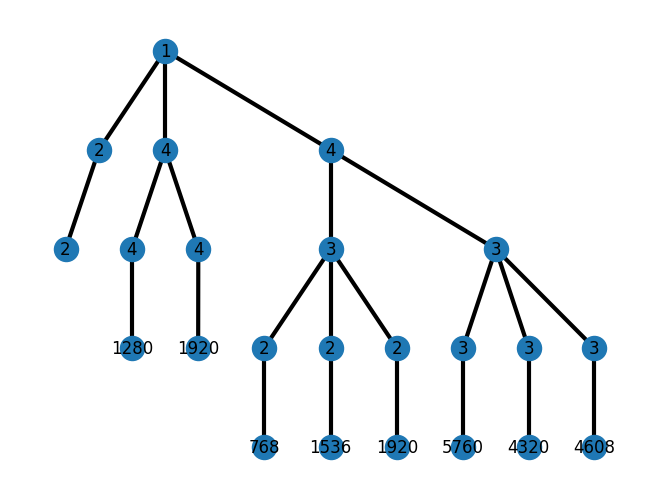

In [12]:
visualise_tree(topo)
plt.show()

### Preparing the `pyttn.sop_operator` Hamiltonian

Now before we are ready to set up and perform the DMRG and TDVP loops, we first need to convert the Hamiltonian into a form that can be used to efficiently within the DMRG and TDVP algorithms.  Further details on this step are provided in the [tutorial on DMRG for the 1D Transverse field Ising model](file/../dmrg_TFIM.ipynb).

In [13]:
#setup the hierarchical SOP hamiltonian
h = pyttn.sop_operator(H, A, sysinf, opdict)

### Running the Dynamics

Now we can have everything we need to set up all of the objects required to perform the TDVP loop and evaluate the autocorrelation.

In [14]:
fs = 41.341374575751

#set up the time evolution parameters
dt = 0.25*fs
tmax = 150*fs
nsteps = int(tmax/(2*dt))+1

#buffer for storing the autocorrelation
auto_corr = np.zeros(nsteps+1, dtype=np.complex128)

#set up the TDVP sweeping object to 
sweep = pyttn.tdvp(A, h, krylov_dim = 12, expansion='subspace', subspace_krylov_dim=12, subspace_neigs=6)

#construct the object used to plot matrix elements
mel = pyttn.matrix_element(A)

#set up the subspace expansion parameters.  Here we expand bond dimension whenever a term in the 
#two-site energy variance (that is not captured within the single-site spaces) has singular value > 1e-5, 
#and do not use natural populations to determine whether to spawn additional basis functions.
sweep.spawning_threshold = 1e-8
sweep.minimum_unoccupied=0
sweep.dt = dt
sweep.coefficient = -1.0j

Now we actually run the dynamics:

In [15]:
import copy
B= copy.deepcopy(A)
B.conj()
auto_corr[0] = mel(B, A)

tp = 0
ninit = 10
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), ninit)
for i in range(ninit):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]

i=1
#set the values after the first timestep
B= copy.deepcopy(A)
B.conj()
auto_corr[i] = mel(B, A)

sweep.dt = dt

#now run the remaining steps
for i in range(1, nsteps):
    sweep.step(A, h)

    B=copy.deepcopy(A)      #copy A into B 
    B.conj()                #and conjugate the result

    auto_corr[i+1] = mel(B, A)    #evaluate <psi(t/2)^*|psi(t/2)>

    print("step: %d of %d.  Chimax: %d. a(t): %f"%(i+1, nsteps, A.maximum_bond_dimension(), np.real(auto_corr[i+1])), end='                   \r', flush=True)


print('                                        \r', flush = True)

                                        07641                                                                            


Now we evaluate the spectra and plot results:

[]

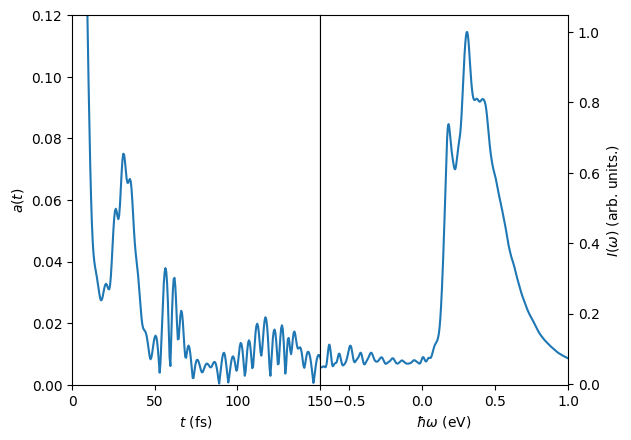

In [16]:
def compute_spectrum(w, Ac, tau, t):
    return np.sum(np.real(Ac*np.exp(-t/tau)*np.cos(np.pi*t/(2*(t[-1])))*np.exp(1.0j*w*t)))*(t[1]-t[0])

eV = 27.211399

t = (np.arange(nsteps+1)*dt*2/fs)
w = np.linspace(0.3, 0.6, 10000) - 0.8460/2
Cw = np.zeros(w.shape)
for i in range(len(w)):
    Cw[i] = compute_spectrum(w[i], auto_corr, 150*fs, t*fs)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(wspace=0, hspace=0)


ax[0].plot(t, np.abs(auto_corr))
ax[0].set_xlim([0, 150])
ax[0].set_ylim([0, 0.12])
ax[0].set_xlabel(r'$t$ (fs)')
ax[0].set_ylabel(r'$a(t)$')

ax[1].plot(w*eV, Cw/np.max(Cw))
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_xlim([-0.7, 1])
ax[1].set_xlabel(r'$\hbar \omega$ (eV)')
ax[1].set_ylabel(r'$I(\omega)$ (arb. units.)')
plt.plot()
